# Basic examples

In this notebook we will show how to fit a model to data, in the **cosmofit** framework.
You need to have installed **cosmofit** with:
```
python -m pip install git+https://github.com/adematti/cosmofit#egg=cosmofit[profilers,samplers]
```

## Model
Let us define a simple, affine model.

In [1]:
from cosmofit.base import BaseCalculator


class AffineModel(BaseCalculator):  # all calculators should inherit from BaseCalculator

    # Model parameters; those can also be declared in a yaml file
    params = {'a': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}},
              'b': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}}}
    
    def __init__(self, x=None):
        self.x = x
        self.requires = {}  # no requirement
    
    def run(self, a=0., b=0.):
        self.y = a * self.x + b  # simple, affine model
    
    # This is only needed for emulation
    def __getstate__(self):
        return {'x': self.x, 'y': self.y}  # dictionary of Python base types and numpy arrays

## Likelihood

Let us define a Gaussian likelihood.

In [2]:
import numpy as np

class Likelihood(BaseCalculator):  # all calculators should inherit from BaseCalculator
    
    def __init__(self):
        # Let us generate some fake data
        self.x = np.linspace(0., 1., 10)
        mean = np.zeros_like(self.x)
        cov = np.eye(len(self.x))
        self.precision = np.linalg.inv(cov)
        rng = np.random.RandomState(seed=42)
        self.y = rng.multivariate_normal(mean, cov)
        # Requirements: name: {'class': ..., 'init': ...}
        self.requires = {'theory': {'class': 'AffineModel', 'init': {'x': self.x}}}
    
    def run(self):
        diff = self.y - self.theory.y  # reauirements are accessed through .name
        self.loglikelihood = -0.5 * diff.dot(self.precision).T.dot(diff)  # chi-square

## Pipeline
Let us build up our likelihood pipeline, that connects the two calculators above.

In [3]:
from cosmofit import LikelihoodPipeline, setup_logging

setup_logging()  # set up logging

config = {}
# We give the likelihood a name, 'like'
# No need to specify other parameters for AffineModel, so no need to mention it
config['like'] = {'class': Likelihood}
likelihood = LikelihoodPipeline(config)

[000000.01] [0/1] 07-29 18:55  LikelihoodPipeline        INFO     Found calculators [Likelihood(like), AffineModel(theory)].
[000000.01] [0/1] 07-29 18:55  LikelihoodPipeline        INFO     Found end calculators [Likelihood(like)].
[000000.01] [0/1] 07-29 18:55  LikelihoodPipeline        INFO     Found likelihood like.


## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [4]:
from cosmofit.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiler.maximize(niterations=5)

[000000.03] [0/1] 07-29 18:55  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].


In [5]:
print(profiler.profiles.to_stats(tablefmt='pretty'))

+--------------+--------+---------+-------+
| chi2 = 17.59 | varied | bestfit | error |
+--------------+--------+---------+-------+
|      a       |  True  |  -0.06  | 0.98  |
|      b       |  True  |  0.48   | 0.58  |
+--------------+--------+---------+-------+


array([<AxesSubplot:ylabel='a'>, <AxesSubplot:ylabel='b'>], dtype=object)

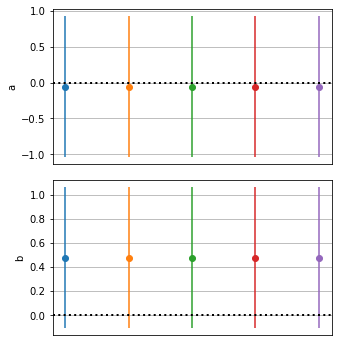

In [6]:
from cosmofit.samples import plotting
# Compare different best fits: all good, no convergence issues!
plotting.plot_aligned_stacked(profiler.profiles, truths=[0., 0.])

In [7]:
# Compute \Delta \chi^{2} = cl^2 = 1 interval for the best best of above best fits
profiler.interval(cl=1)
print(profiler.profiles.to_stats(tablefmt='latex_raw'))

\begin{tabular}{lllll}
\hline
 $\chi^{2} = 17.59$   & varied   & bestfit   & error   & interval             \\
\hline
 a                    & True     & $-0.06$   & $0.98$  & ${}_{-0.98}^{+0.98}$ \\
 b                    & True     & $0.48$    & $0.58$  & ${}_{-0.58}^{+0.58}$ \\
\hline
\end{tabular}


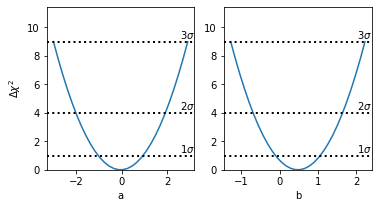

In [8]:
# Profile posterior up to cl = 3 sigmas
profiler.profile(cl=3)
# And plot, removing \chi^{2} at best fit
plotting.plot_profile(profiler.profiles, offsets=-2 * profiler.profiles.bestfit.logposterior.max())

## Sample
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [9]:
from cosmofit.samplers import EmceeSampler

# By default are running 1 chain
# We can as for me, e.g. chains=2
# MPI processes will be evenly split across all the chains
sampler = EmceeSampler(likelihood, seed=42, nwalkers=10)
# We run samples until convergence, considered reach when Gelman-Rubin (computed over 4 chain subsamples) < 0.03; 
converged = False
while not converged:
    sampler.run()
    converged = sampler.check(eigen_gr_stop=0.03)

[000002.60] [0/1] 07-29 18:55  EmceeSampler              INFO     Varied parameters: ['a', 'b'].
[000004.34] [0/1] 07-29 18:55  EmceeSampler              INFO     Diagnostics:
[000004.35] [0/1] 07-29 18:55  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0878 > 0.03.
[000004.36] [0/1] 07-29 18:55  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 is 0.0917.
[000004.38] [0/1] 07-29 18:55  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.512.
[000004.38] [0/1] 07-29 18:55  EmceeSampler              INFO     - max Geweke is 0.329.
[000004.40] [0/1] 07-29 18:55  EmceeSampler              INFO     - max integrated autocorrelation time is 12.4.
[000005.81] [0/1] 07-29 18:55  EmceeSampler              INFO     Diagnostics:
[000005.81] [0/1] 07-29 18:55  EmceeSampler              INFO     - max eigen Gelman-Rubin - 1 is 0.0535 > 0.03.
[000005.82] [0/1] 07-29 18:55  EmceeSampler              INFO     - max diag Gelman-Rubin - 1 

In [10]:
# Let's remove burnin and get basic stats
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+---+--------+------+--------+------+-----------------+-----------------+
|   | argmax | mean | median | std  | quantile:1sigma | interval:1sigma |
+---+--------+------+--------+------+-----------------+-----------------+
| a |  -0.1  | -0.1 |  -0.1  | 1.1  |    -1.0/+1.0    |   -0.92/+1.13   |
| b |  0.48  | 0.49 |  0.51  | 0.96 |   -0.60/+0.60   |   -0.53/+0.66   |
+---+--------+------+--------+------+-----------------+-----------------+


[000012.53] [0/1] 07-29 18:55  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in
[000012.82] [0/1] 07-29 18:55  root                      WARNING  fine_bins_2D not large enough for optimal density: a, b


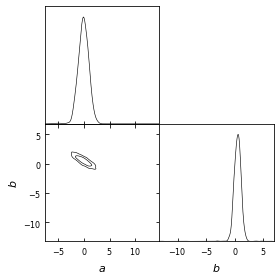

In [11]:
# This actually uses GetDist
# chain.to_getdist() will return a getdist.MCSamples object to play further
plotting.plot_triangle(chain)

## Emulate
If our model took years to run, we would likely want to emulate it. Let us try this on this simple model.

[000013.35] [0/1] 07-29 18:55  TaylorEmulatorEngine      INFO     Varied parameters: ['a', 'b'].
[000013.35] [0/1] 07-29 18:55  TaylorEmulatorEngine      INFO     Found varying {'y'} and fixed ['x'] outputs.
[000013.66] [0/1] 07-29 18:55  TaylorEmulatorEngine      INFO     Diagnostics:
[000013.66] [0/1] 07-29 18:55  TaylorEmulatorEngine      INFO     - mse of y is 2.82e-35 (square root = 5.31e-18).


array([<AxesSubplot:ylabel='y'>, <AxesSubplot:ylabel='$\\Delta$ y'>],
      dtype=object)

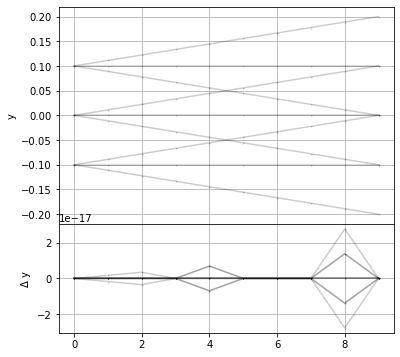

In [12]:
from cosmofit.base import BasePipeline
from cosmofit.emulators import TaylorEmulatorEngine

# We stop the pipeline to the calculator we want to emulate, i.e. theory (AffineModel)
pipeline = likelihood.select('theory', type=BasePipeline)
# Let us perform a Taylor expansion of order 1
# Attributes of AffineModel instance, obtained through theory.__getstate__()
# are automatically split between varied and fixed categories
emulator = TaylorEmulatorEngine(pipeline, order=1)
emulator.set_samples()
emulator.fit()
emulator.check()  # since model is linear, non-zero mse is just numerical noise
emulator.plot()  # plot some theory.y samples, and the difference emulator - model at the bottom; all good!

In [13]:
# No dump the emulator to disk
import os

base_dir = '_tests'
fn = os.path.join(base_dir, 'emulator.npy')
emulator.save(fn)

[000013.94] [0/1] 07-29 18:55  TaylorEmulatorEngine      INFO     Saving _tests/emulator.npy.
[000013.94] [0/1] 07-29 18:55  TaylorEmulatorEngine      INFO     Saving _tests/emulator.yaml.


In [14]:
# A yaml file is exported, which helps recollect the parameters of the emulator
# The parameters that have been varied should be specified when using this emulator,
# other parameters (fixed) can be removed if necessary
with open(fn.replace('.npy', '.yaml')) as file:
    print(file.read())

class: AffineModel
info: {}
init:
  x: [0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444,
    0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888,
    1.0]
params:
  a:
    derived: false
    fixed: false
    latex: None
    prior:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    proposal: 10.0
    ref:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    value: 0.0
  b:
    derived: false
    fixed: false
    latex: None
    prior:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    proposal: 10.0
    ref:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    value: 0.0



In [15]:
# Now let us load our emulator into the pipeline
config = {}
config['like'] = {'class': Likelihood}
config['theory'] = {'class': 'AffineModel', 'load': fn}
likelihood = LikelihoodPipeline(config)

[000013.97] [0/1] 07-29 18:55  AffineModel               INFO     Loading _tests/emulator.npy.
[000013.97] [0/1] 07-29 18:55  PipelineConfig            INFO     Loading config file _tests/emulator.yaml
[000014.00] [0/1] 07-29 18:55  LikelihoodPipeline        INFO     Found calculators [Likelihood(like), AffineModel(theory)].
[000014.00] [0/1] 07-29 18:55  LikelihoodPipeline        INFO     Found end calculators [Likelihood(like)].
[000014.01] [0/1] 07-29 18:55  LikelihoodPipeline        INFO     Found likelihood like.


[000014.04] [0/1] 07-29 18:55  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].


array([<AxesSubplot:ylabel='a'>, <AxesSubplot:ylabel='b'>], dtype=object)

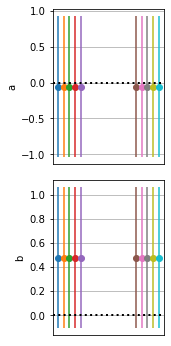

In [16]:
from cosmofit.profilers import MinuitProfiler

profiler2 = MinuitProfiler(likelihood, seed=42)
profiler2.maximize(niterations=5)
plotting.plot_aligned_stacked([profiler2.profiles, profiler.profiles], truths=[0., 0.])
# Fits with the emulator and the model are the same, all good!